In [90]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


In [91]:
def variety_checker(mylist):
    checker =[]
    for each in mylist:
        if not each in checker:
            checker.append(each)
    return checker

In [92]:
datalink = '/kaggle/input/playground-series-s4e9/train.csv'

train = pd.DataFrame(pd.read_csv(datalink))
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,188533.0,94266.000000,54424.933488,0.0,47133.0,94266.0,141399.0,188532.0
model_year,188533.0,2015.829998,5.660967,1974.0,2013.0,2017.0,2020.0,2024.0
milage,188533.0,65705.295174,49798.158076,100.0,24115.0,57785.0,95400.0,405000.0
price,188533.0,43878.016178,78819.522254,2000.0,17000.0,30825.0,49900.0,2954083.0


In [7]:
train.isna().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

According to describe and sum methods,

* I can extract the fuel information from 'engine'
* Accident will be filled out with the mean value.
* Clean will be filled out with the mean value.
* The age of the car will be calculated from the model year



In [8]:
len(train['engine'])

188533

# Traditional ML SOLUTION with cleaning the data

In [93]:
def data_process(data):
    
    import re
    

    #if the car is TESLA,:
# ----------------------------------------------------------------------------------------   
    #data has some defectives such as even though the car is Tesla fuel_type was entered as Gasoline or nothing written. It is easy to make them correct:
    tesla_fuel = []
    data['brand'] == 'Tesla'
    data.loc[data['brand'] == 'Tesla','fuel_type'] = 'Electric'
    
    
    #how old the car is:
# ----------------------------------------------------------------------------------------       
    year = 2024
    car_year_list = year-data['model_year']
    data['Age'] = car_year_list
    data = data.drop('model_year',axis =1)
    
    
    #HP information from  engine:
# ----------------------------------------------------------------------------------------    
    engine_data = data['engine']
    k = []
    for each in engine_data:
        match_hp= re.search(r'([0-9.]+)\s*HP', each, re.IGNORECASE)
        if match_hp:
            hp_value =float(match_hp.group(1))
        else:
            hp_value = 0
        k.append(hp_value)
    data['HP'] = k
    
    
    #Engine Volume from engine:
# ----------------------------------------------------------------------------------------    

    k = []
    engine_data = data['engine']
    for each in engine_data:
        match_liter= re.search(r'([0-9.]+)\s*(L|Liter)', each)
        if match_liter:
            liter_value =float(match_liter.group(1))
        else:
            liter_value = 0
        k.append(liter_value)
    data['engine_liter'] = k
    
    

    #Cylinder info from engine 
# ----------------------------------------------------------------------------------------    

#if the cylinder info is obvious in engine data
    volume_cylinder = []
    cylinder_value = 0
    engine_data = data['engine']
    
    for each in engine_data:
        #print(each)
        
        match_cylinder = re.search(r'(\b[0-9]+)\s*Cylinder', each) 
        
        if match_cylinder:
            k = float(match_cylinder.group(1))
        else:
            k = 0
        volume_cylinder.append(k)
        
#else:
    volume_V = []
    cylinder_value = 0
    engine_data = data['engine']
    for each in engine_data: 
        match_V = re.search(r'(\b[0-9]+)?\s*(V([0-9]+))', each)
        if match_V:
            k = float(match_V.group(3))
        else:
            k = 0
        volume_V.append(k)
    volume = np.array(volume_V) + np.array(volume_cylinder)
    data['cylinder'] = volume
   
    
    #transmission classification
# ----------------------------------------------------------------------------------------   
    categories = []
    cat_num = []
    transmissions = data['transmission']
    for transmission in transmissions:
        if 'CVT' in transmission:
            categories.append('CVT')
            cat_num.append(0)
        elif 'Automatic' in transmission or 'A/T' in transmission:
            if 'with Auto-Shift' in transmission or 'Dual Shift Mode' in transmission or 'DCT' in transmission:
                categories.append('Auto-Shift')
                cat_num.append(1)
            else:
                categories.append('Automatic')
                cat_num.append(2)
        elif 'M/T' in transmission or 'Manual' in transmission:
            categories.append('Manual')
            cat_num.append(3)
        else:
            categories.append('Special/Other')
            cat_num.append(4)
        
    data['mode']= categories     #after visualisation, it will be dropped.
    data['transmission_class'] = cat_num #instead of above, it will be used
    
    
    return data

In [94]:
t = data_process(train)
t.head(10)

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Age,HP,engine_liter,cylinder,mode,transmission_class
0,0,MINI,Cooper S Base,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,17,172.0,1.6,4.0,Automatic,2
1,1,Lincoln,LS V8,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,252.0,3.9,8.0,Automatic,2
2,2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,22,320.0,5.3,8.0,Automatic,2
3,3,Genesis,G90 5.0 Ultimate,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,7,420.0,5.0,8.0,Special/Other,4
4,4,Mercedes-Benz,Metris Base,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,3,208.0,2.0,4.0,Automatic,2
5,5,Audi,A6 2.0T Sport,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950,6,252.0,2.0,4.0,Automatic,2
6,6,Audi,A8 L 3.0T,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500,8,333.0,3.0,6.0,Automatic,2
7,7,Chevrolet,Silverado 1500 1LZ,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500,8,355.0,5.3,8.0,Automatic,2
8,8,Ford,F-150 XLT,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890,4,0.0,2.7,6.0,Automatic,2
9,9,BMW,M4 Base,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000,9,425.0,3.0,6.0,Special/Other,4


In [95]:
#Which Brand are so popular: 

total_car = len(t['brand'])
brand_type = variety_checker(t['brand'])
dict_car = {}

for each in brand_type:
    lenght = len(t[t['brand']==each])
    percentage = round((lenght / total_car) * 100, 2)
    dict_car[each] = percentage    
cnt_v = 0
cnt_k = 0
remove_car = []
remain_car = {}
for k,v in dict_car.items():
    if v > 0.6:         
        cnt_v = cnt_v +v
        cnt_k = cnt_k +1
        remain_car[k] = v    
    else:
        remove_car.append(k)
            
car_remove = len(variety_checker(t['brand'])) - cnt_k
print('by removing {0} different brands, our data is still preserved at {1}'.format(car_remove, round(cnt_v,2)))

print('Removing car is :',remove_car)
print('Remaing car:',remain_car)

by removing 30 different brands, our data is still preserved at 94.12
Removing car is : ['MINI', 'Genesis', 'Volvo', 'Buick', 'Rivian', 'Hummer', 'Alfa', 'McLaren', 'Mitsubishi', 'Rolls-Royce', 'Maserati', 'Pontiac', 'Saturn', 'Ferrari', 'Aston', 'Lamborghini', 'Chrysler', 'Lucid', 'Lotus', 'Scion', 'smart', 'Karma', 'Plymouth', 'Suzuki', 'FIAT', 'Saab', 'Bugatti', 'Mercury', 'Polestar', 'Maybach']
Remaing car: {'Lincoln': 1.29, 'Chevrolet': 8.66, 'Mercedes-Benz': 10.17, 'Audi': 5.77, 'Ford': 12.25, 'BMW': 9.03, 'Tesla': 1.98, 'Cadillac': 2.48, 'Land': 5.05, 'GMC': 1.71, 'Toyota': 4.69, 'Hyundai': 1.08, 'Volkswagen': 0.94, 'RAM': 2.25, 'INFINITI': 1.74, 'Jeep': 3.43, 'Porsche': 5.63, 'Honda': 1.11, 'Lexus': 4.58, 'Dodge': 1.66, 'Nissan': 2.08, 'Jaguar': 0.7, 'Acura': 1.21, 'Kia': 1.32, 'Bentley': 0.61, 'Mazda': 1.44, 'Subaru': 1.26}


In [96]:
remain_car.keys()

dict_keys(['Lincoln', 'Chevrolet', 'Mercedes-Benz', 'Audi', 'Ford', 'BMW', 'Tesla', 'Cadillac', 'Land', 'GMC', 'Toyota', 'Hyundai', 'Volkswagen', 'RAM', 'INFINITI', 'Jeep', 'Porsche', 'Honda', 'Lexus', 'Dodge', 'Nissan', 'Jaguar', 'Acura', 'Kia', 'Bentley', 'Mazda', 'Subaru'])

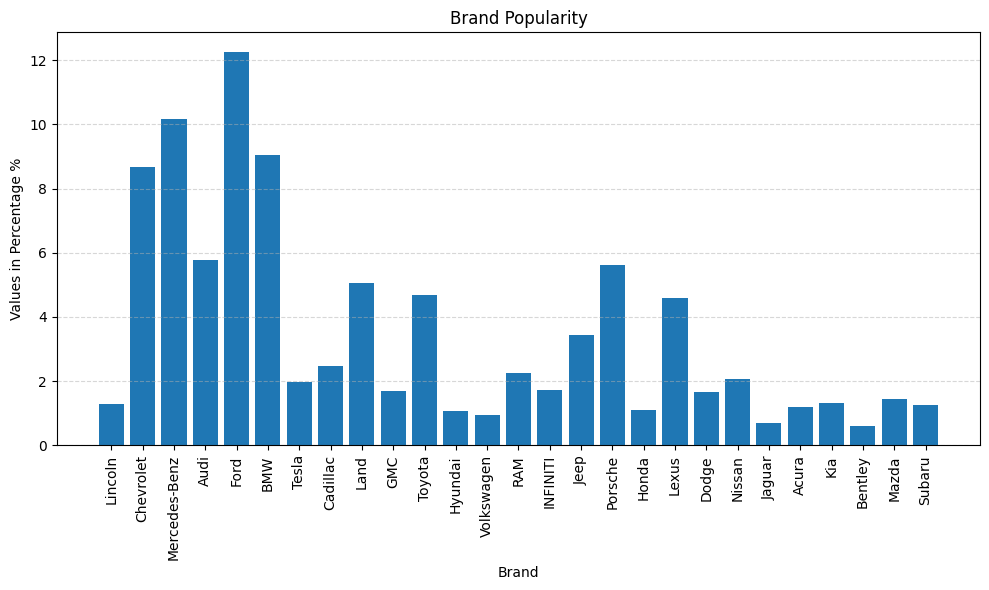

In [97]:
import matplotlib.pyplot as plt


# Extract keys and values
keys = list(remain_car.keys())
values = list(remain_car.values())

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(keys, values)
plt.xlabel('Brand')
plt.ylabel('Values in Percentage %')
plt.title('Brand Popularity')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Adding a grid to the y-axis
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [14]:
t.head()

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Age,HP,engine_liter,cylinder,mode,transmission_class
0,0,MINI,Cooper S Base,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,17,172.0,1.6,4.0,Automatic,2
1,1,Lincoln,LS V8,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,252.0,3.9,8.0,Automatic,2
2,2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,22,320.0,5.3,8.0,Automatic,2
3,3,Genesis,G90 5.0 Ultimate,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,7,420.0,5.0,8.0,Special/Other,4
4,4,Mercedes-Benz,Metris Base,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,3,208.0,2.0,4.0,Automatic,2


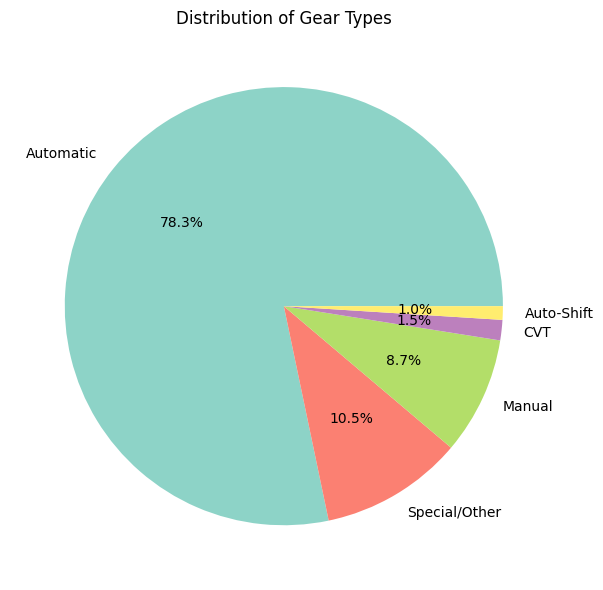

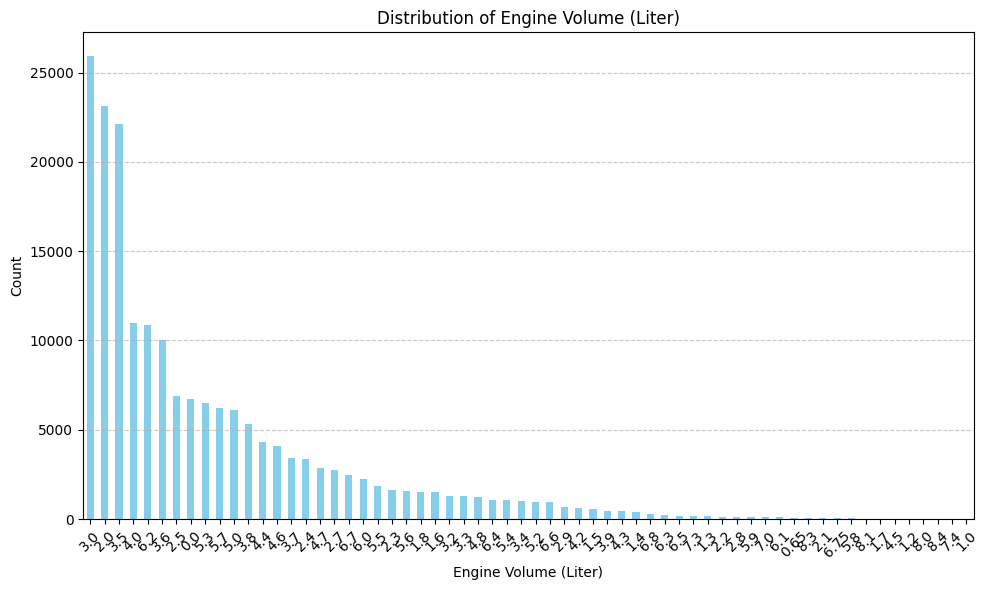

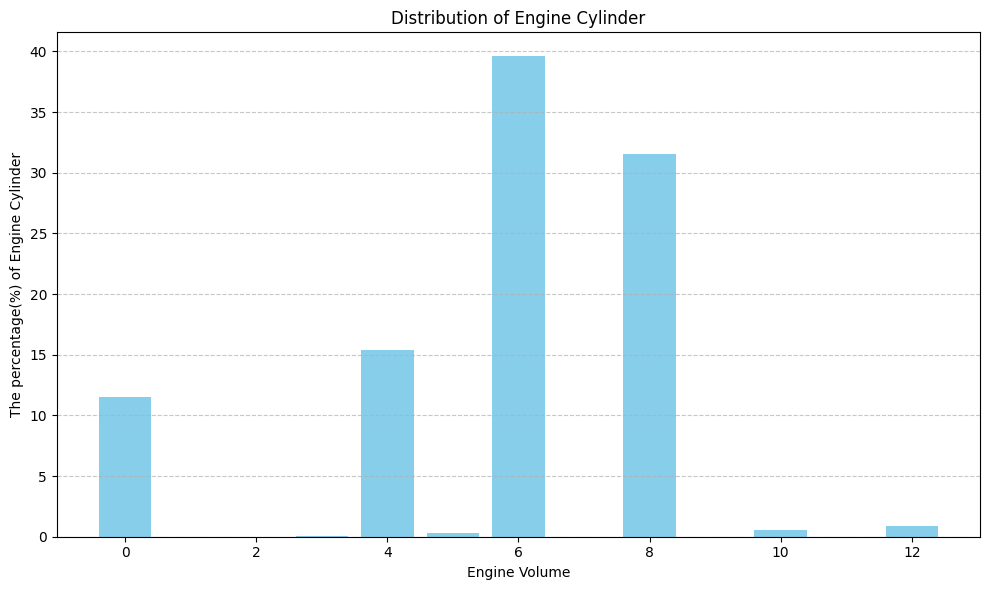

In [98]:
#PLOTTING
# ----------------------------------------------------------------------------------------  

#Gear Types
# -------------------------------------
plt.figure(figsize=(10, 6))
t['mode'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=0, cmap='Set3')  # Added 'autopct' to show percentages
plt.title('Distribution of Gear Types')
plt.ylabel('')  # Remove the y-label for better readability
plt.tight_layout()  # Adjust layout
plt.show()  # Display the pie chart

#Engine Volume Types
# -------------------------------------
plt.figure(figsize=(10, 6))
t['engine_liter'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Engine Volume (Liter)')
plt.xlabel('Engine Volume (Liter)')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding grid for better readability
plt.tight_layout()  # Adjust layout
plt.show()  # Display the bar chart

#Engine Cylinder Types
# -------------------------------------
dt_cylinder = t['cylinder'].value_counts().to_dict()
cy_max = len(t['cylinder'])

cylinder_rate = {}
for k,v in dt_cylinder.items():
    cylinder_rate[k] = round((v/cy_max)*100,2)
    
sortkeys = list(cylinder_rate.keys())
sortvalues = list(cylinder_rate.values())

plt.figure(figsize=(10, 6))
plt.bar(sortkeys, sortvalues, color='skyblue')
plt.xlabel('Engine Volume')
plt.ylabel('The percentage(%) of Engine Cylinder')
plt.title('Distribution of Engine Cylinder')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding gridlines for readability
plt.tight_layout()  # Adjust layout for clarity
plt.show()


#Engine Volume Weight
# -------------------------------------



In [99]:
#Dropping
# ----------------------------------------------------------------------------------------  

#Cylinder Drop
# -------------------------------------
remain_cylinder = {}
for k,v in cylinder_rate.items():
    if v > 0.4 : #We can ignore V3, V5 and V10 engines
        remain_cylinder[k] = v
remain_cylinder = list(remain_cylinder.keys())
dt = t[t['cylinder'].isin(remain_cylinder)]
preserve_data = round((len(dt)/len(t))*100,2)
print('if volume > %0.4 filtered; the data is preserved at {}%:'.format(preserve_data))
        
#Brand Drop
# -------------------------------------
wanted_car_list =  remain_car.keys()
dt_car = dt[dt['brand'].isin(wanted_car_list)]
preserve_data = round((len(dt_car)/len(dt))*100,2)
print('if brand > %0.6 filtered; the data is preserved at {}%:'.format(preserve_data))




if volume > %0.4 filtered; the data is preserved at 99.59%:
if brand > %0.6 filtered; the data is preserved at 94.32%:


In [100]:
dt_car.head(10)

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Age,HP,engine_liter,cylinder,mode,transmission_class
1,1,Lincoln,LS V8,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,252.0,3.9,8.0,Automatic,2
2,2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,22,320.0,5.3,8.0,Automatic,2
4,4,Mercedes-Benz,Metris Base,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,3,208.0,2.0,4.0,Automatic,2
5,5,Audi,A6 2.0T Sport,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950,6,252.0,2.0,4.0,Automatic,2
6,6,Audi,A8 L 3.0T,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500,8,333.0,3.0,6.0,Automatic,2
7,7,Chevrolet,Silverado 1500 1LZ,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500,8,355.0,5.3,8.0,Automatic,2
8,8,Ford,F-150 XLT,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890,4,0.0,2.7,6.0,Automatic,2
9,9,BMW,M4 Base,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000,9,425.0,3.0,6.0,Special/Other,4
10,10,Chevrolet,Camaro 1LT,212500,Gasoline,312.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Gray,At least 1 accident or damage reported,Yes,7950,13,312.0,3.6,6.0,Automatic,2
11,11,Tesla,Model S P100D,81500,Electric,Electric Motor Electric Fuel System,1-Speed A/T,Gray,White,None reported,Yes,19000,9,0.0,0.0,0.0,Automatic,2


In [101]:
def fuel_and_cylinder(data):
    #lets transform categorical information to numerical information
# ----------------------------------------------------------------------------------------

#Fuel_type
# -------------------------------------
    fuel_data = []
    #print(dt_car['fuel_type'].value_counts())

    for each in data['fuel_type']:
        if each == 'Gasoline':
            fuel_data.append(0)
        elif each == 'Hybrid':
            fuel_data.append(1)
        elif each == 'E85 Flex Fuel':
            fuel_data.append(2)
        elif each == 'Electric':
            fuel_data.append(3)
        elif each == 'Diesel':
            fuel_data.append(4)
        elif each == '–':
            fuel_data.append(5)
        elif each == 'Plug-In Hybrid':
            fuel_data.append(6)
        else:
            fuel_data.append(7)
    data['fuel_class'] = fuel_data

    #Cylinder_type
    # -------------------------------------
    volume = []

    for each in data['cylinder']:
        if each == 4.0:
            volume.append(0)
        elif each == 6.0:
            volume.append(1)
        elif each == 8.0:
            volume.append(2)
        elif each == 10.0:
            volume.append(3)
        elif each == 12.0:
            volume.append(4)
        elif each == 0.0:
            volume.append(5)
        else:
            volume.append(6)
    data['cylinder'] = volume
    
    return data


In [102]:
dt_car = fuel_and_cylinder(dt_car)

/tmp/ipykernel_36/950466427.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['fuel_class'] = fuel_data
/tmp/ipykernel_36/950466427.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cylinder'] = volume


In [61]:
'''
#lets transform categorical information to numerical information
# ----------------------------------------------------------------------------------------

#Fuel_type
# -------------------------------------
fuel_data = []
#print(dt_car['fuel_type'].value_counts())

for each in dt_car['fuel_type']:
    if each == 'Gasoline':
        fuel_data.append(0)
    elif each == 'Hybrid':
        fuel_data.append(1)
    elif each == 'E85 Flex Fuel':
        fuel_data.append(2)
    elif each == 'Electric':
        fuel_data.append(3)
    elif each == 'Diesel':
        fuel_data.append(4)
    elif each == '–':
        fuel_data.append(5)
    elif each == 'Plug-In Hybrid':
        fuel_data.append(6)
    else:
        fuel_data.append(7)
dt_car['fuel_class'] = fuel_data

#Cylinder_type
# -------------------------------------
volume = []

for each in dt_car['cylinder']:
    if each == 4.0:
        volume.append(0)
    elif each == 6.0:
        volume.append(1)
    elif each == 8.0:
        volume.append(2)
    elif each == 10.0:
        volume.append(3)
    elif each == 12.0:
        volume.append(4)
    elif each == 0.0:
        volume.append(5)
    else:
        volume.append(6)
dt_car['cylinder'] = volume
'''

"\n#lets transform categorical information to numerical information\n# ----------------------------------------------------------------------------------------\n\n#Fuel_type\n# -------------------------------------\nfuel_data = []\n#print(dt_car['fuel_type'].value_counts())\n\nfor each in dt_car['fuel_type']:\n    if each == 'Gasoline':\n        fuel_data.append(0)\n    elif each == 'Hybrid':\n        fuel_data.append(1)\n    elif each == 'E85 Flex Fuel':\n        fuel_data.append(2)\n    elif each == 'Electric':\n        fuel_data.append(3)\n    elif each == 'Diesel':\n        fuel_data.append(4)\n    elif each == '–':\n        fuel_data.append(5)\n    elif each == 'Plug-In Hybrid':\n        fuel_data.append(6)\n    else:\n        fuel_data.append(7)\ndt_car['fuel_class'] = fuel_data\n\n#Cylinder_type\n# -------------------------------------\nvolume = []\n\nfor each in dt_car['cylinder']:\n    if each == 4.0:\n        volume.append(0)\n    elif each == 6.0:\n        volume.append(1)\n

In [103]:
dt_car.head()

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Age,HP,engine_liter,cylinder,mode,transmission_class,fuel_class
1,1,Lincoln,LS V8,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,252.0,3.9,2,Automatic,2,0
2,2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,22,320.0,5.3,2,Automatic,2,2
4,4,Mercedes-Benz,Metris Base,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,3,208.0,2.0,0,Automatic,2,0
5,5,Audi,A6 2.0T Sport,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950,6,252.0,2.0,0,Automatic,2,0
6,6,Audi,A8 L 3.0T,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500,8,333.0,3.0,1,Automatic,2,0


In [104]:
#Volume_type
# -------------------------------------

k=dt_car['engine_liter'].value_counts().to_dict()
engine_vol_selected ={}
deleted_vol_selected = {}
sum_engine = 0
sum_delete = 0
for k,v in k.items():

    #print(k,':',v)
    if  v> 1000:
        engine_vol_selected[k] = v
        sum_engine += v 
    else:
       sum_delete +=v 
       deleted_vol_selected[k] = v

print('Deleted Engine Vol:', deleted_vol_selected.keys()) 
print('Effect of Deleted Engine Vol in data: %', (sum_delete*100/(sum_delete+sum_engine)))

# Filtering data based on selected engine volumes
engine_data = dt_car[dt_car['engine_liter'].isin(engine_vol_selected.keys())]
print('the data size is now from {} to {}'.format(len(dt_car),len(engine_data)))

Deleted Engine Vol: dict_keys([6.6, 1.6, 5.2, 2.9, 4.2, 1.5, 4.3, 1.4, 3.9, 6.8, 6.3, 7.3, 1.3, 2.2, 2.8, 7.0, 6.1, 5.9, 0.65, 8.3, 2.1, 6.75, 5.8, 8.1, 1.7, 6.5, 4.5, 1.2, 8.4, 7.4, 8.0])
Effect of Deleted Engine Vol in data: % 3.351195080773118
the data size is now from 177101 to 171166


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, '3.0'),
  Text(1, 0, '3.5'),
  Text(2, 0, '2.0'),
  Text(3, 0, '6.2'),
  Text(4, 0, '4.0'),
  Text(5, 0, '3.6'),
  Text(6, 0, '5.3'),
  Text(7, 0, '5.7'),
  Text(8, 0, '2.5'),
  Text(9, 0, '0.0'),
  Text(10, 0, '5.0'),
  Text(11, 0, '3.8'),
  Text(12, 0, '4.4'),
  Text(13, 0, '4.6'),
  Text(14, 0, '3.7'),
  Text(15, 0, '2.4'),
  Text(16, 0, '4.7'),
  Text(17, 0, '2.7'),
  Text(18, 0, '6.7'),
  Text(19, 0, '6.0'),
  Text(20, 0, '5.5'),
  Text(21, 0, '2.3'),
  Text(22, 0, '5.6'),
  Text(23, 0, '1.8'),
  Text(24, 0, '4.8'),
  Text(25, 0, '3.2'),
  Text(26, 0, '6.4'),
  Text(27, 0, '3.3'),
  Text(28, 0, '5.4'),
  Text(29, 0, '3.4')])

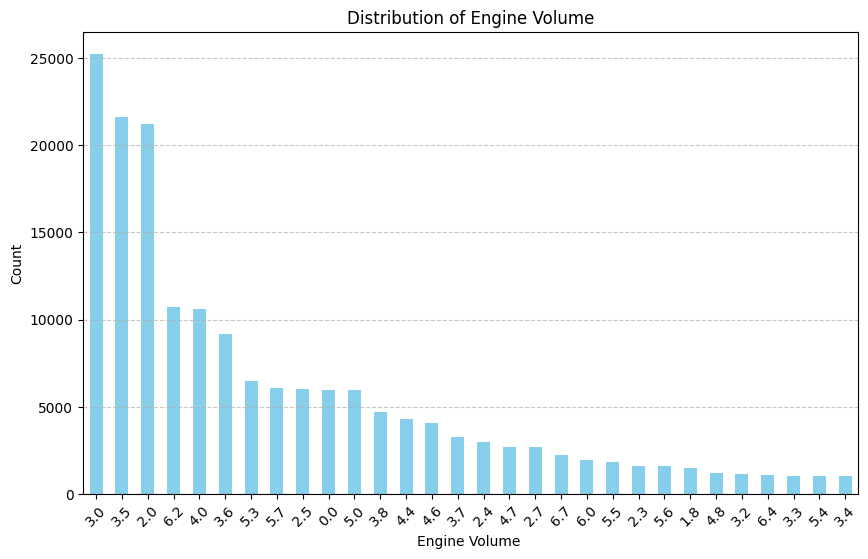

In [105]:
# Plotting the distribution of engine volume
plt.figure(figsize=(10, 6))
engine_data['engine_liter'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Engine Volume')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding gridlines for readability
plt.xlabel('Engine Volume ')
plt.ylabel('Count')
plt.xticks(rotation=45)


/tmp/ipykernel_36/4243612782.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engine_data['engine_liter'] = new_list


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '3'),
  Text(1, 0, '2'),
  Text(2, 0, '5'),
  Text(3, 0, '4'),
  Text(4, 0, '6'),
  Text(5, 0, '0'),
  Text(6, 0, '1')])

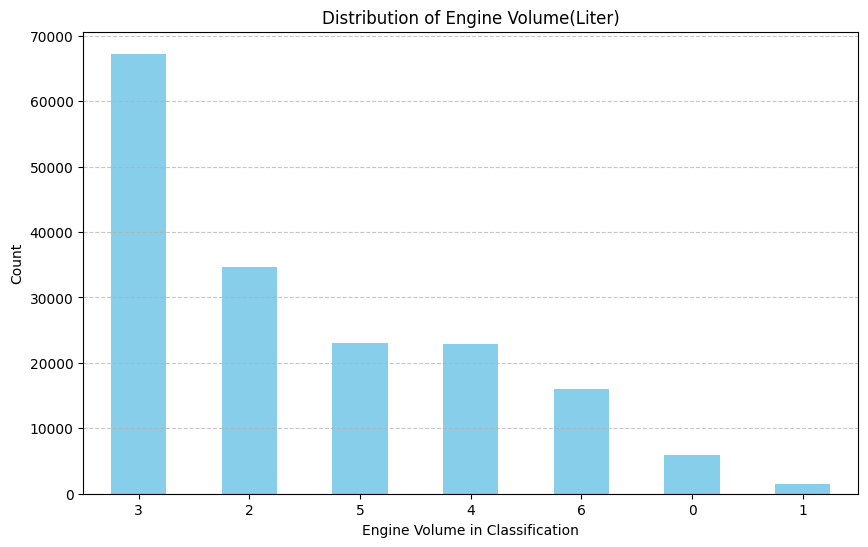

In [106]:
engine_list=engine_data['engine_liter']
new_list = []

for each in engine_list:
    if each < 1:
            new_list.append(0)
    elif each < 2:
            new_list.append(1)
    elif each < 3:
            new_list.append(2)
    elif each < 4:
            new_list.append(3)
    elif each < 5:
            new_list.append(4)
    elif each < 6:
            new_list.append(5)
    elif each < 7:
            new_list.append(6)
    elif each < 8:
            new_list.append(7)
engine_data['engine_liter'] = new_list

# Plotting the distribution of engine volume
plt.figure(figsize=(10, 6))
engine_data['engine_liter'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Engine Volume(Liter)')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding gridlines for readability
plt.xlabel('Engine Volume in Classification')
plt.ylabel('Count')
plt.xticks(rotation=0)


In [107]:
engine_data.head(10)

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Age,HP,engine_liter,cylinder,mode,transmission_class,fuel_class
2,2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,22,320.0,5,2,Automatic,2,2
4,4,Mercedes-Benz,Metris Base,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,3,208.0,2,0,Automatic,2,0
5,5,Audi,A6 2.0T Sport,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950,6,252.0,2,0,Automatic,2,0
6,6,Audi,A8 L 3.0T,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500,8,333.0,3,1,Automatic,2,0
7,7,Chevrolet,Silverado 1500 1LZ,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500,8,355.0,5,2,Automatic,2,2
8,8,Ford,F-150 XLT,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890,4,0.0,2,1,Automatic,2,0
9,9,BMW,M4 Base,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000,9,425.0,3,1,Special/Other,4,0
10,10,Chevrolet,Camaro 1LT,212500,Gasoline,312.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Gray,At least 1 accident or damage reported,Yes,7950,13,312.0,3,1,Automatic,2,0
11,11,Tesla,Model S P100D,81500,Electric,Electric Motor Electric Fuel System,1-Speed A/T,Gray,White,None reported,Yes,19000,9,0.0,0,5,Automatic,2,3
12,12,Cadillac,Escalade ESV Platinum,93971,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Black,None reported,Yes,51500,7,420.0,6,2,Automatic,2,0


/tmp/ipykernel_36/809132597.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engine_data['HP_class'] = new_list


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '4'),
  Text(1, 0, '3'),
  Text(2, 0, '1'),
  Text(3, 0, '5'),
  Text(4, 0, '6'),
  Text(5, 0, '2'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '10'),
  Text(9, 0, '9')])

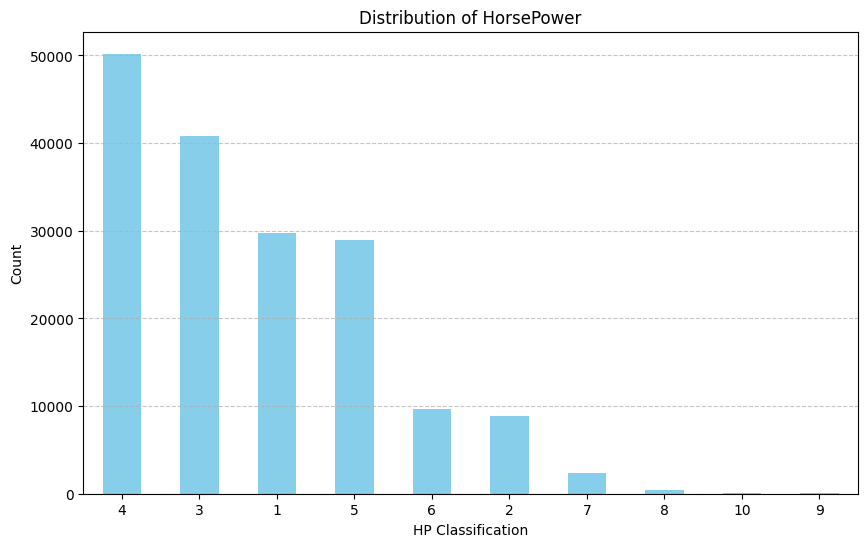

In [108]:
#HorsePower_type
# -------------------------------------

hp_list=engine_data['HP']
new_list = []

for each in hp_list:
    if each < 100:
            new_list.append(1)
    elif each < 200:
            new_list.append(2)
    elif each < 300:
            new_list.append(3)
    elif each < 400:
            new_list.append(4)
    elif each < 500:
            new_list.append(5)
    elif each < 600:
            new_list.append(6)
    elif each < 700:
            new_list.append(7)
    elif each < 800:
            new_list.append(8)
    elif each < 900:
            new_list.append(9)
    else: 
        new_list.append(10)

engine_data['HP_class'] = new_list

# Plotting the distribution of engine volume
plt.figure(figsize=(10, 6))
engine_data['HP_class'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of HorsePower')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding gridlines for readability
plt.xlabel('HP Classification')
plt.ylabel('Count')
plt.xticks(rotation=0)



['None reported', 'At least 1 accident or damage reported', nan]
[0, 1, nan]


/tmp/ipykernel_36/2015650311.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engine_data['accident_class'] = modified_newlist


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

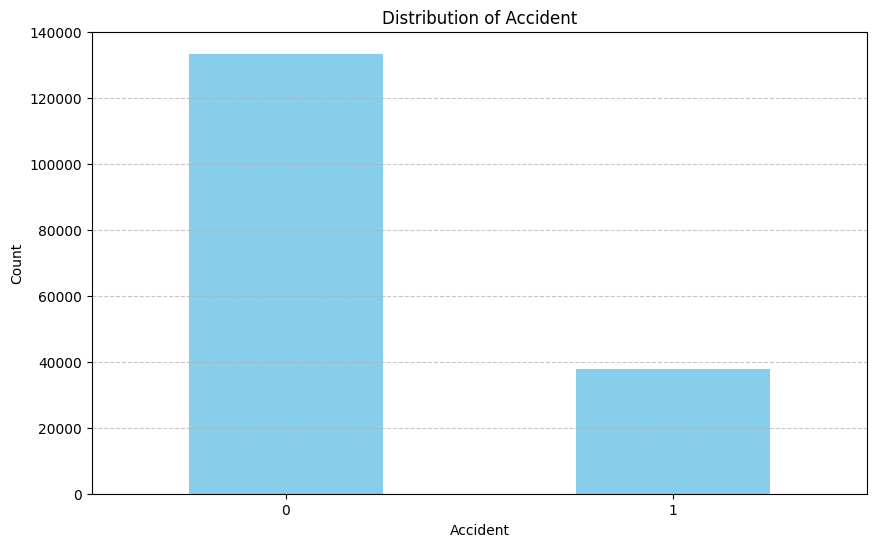

In [109]:
print(variety_checker(engine_data['accident']))

mylist = engine_data['accident']
newlist = []
ctr = []

for each in mylist:
    if each == 'None reported':
        newlist.append(0)
        ctr.append(0)
    elif each == 'At least 1 accident or damage reported':
        newlist.append(1)
        ctr.append(1)
    else:
        newlist.append(each) #first of all, i want not to touch NA then i will calculate mean value for nan to be filled
print(variety_checker(newlist))
 
meanvalue = sum(ctr)/len(ctr)
if meanvalue < 0.5:
    x = 0
else:
    x = 1
modified_newlist = [x if each not in [0, 1] else each for each in newlist]

engine_data['accident_class'] = modified_newlist

# Plotting the distribution of engine volume
plt.figure(figsize=(10, 6))
engine_data['accident_class'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Accident')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding gridlines for readability
plt.xlabel('Accident')
plt.ylabel('Count')
plt.xticks(rotation=0)



In [110]:
def color_grouping(checker,ext_color, mydata):
    mylist = []

    
    if checker == 0:
        int_or_ext = 'ext_col'
        pre_engine_data = 'ext_class'
    else: 
        int_or_ext = 'int_col'
        pre_engine_data = 'int_class'


    loop_data = mydata[int_or_ext]
    for each in loop_data: #engine_data['int_col' or 'ext_col']
        matched = False  # Initialize a flag to track if a match is found
        
        # Iterate over ext_color dictionary to get both keys and values
        for k, (color, keywords) in enumerate(ext_color.items()):
            if any(keyword.lower() in each.lower() for keyword in keywords):
                mylist.append(k)  # Append the index if a match is found
                matched = True
                break  # Exit the loop once a match is found
        
        if not matched:
            mylist.append(len(ext_color))  # Append a default index (e.g., the length of ext_color) if no match is found
            
    i = 0 
    abb = {}
    for each in ext_color.keys():
        abb[each] =i
        i = i+1
    
    mydata[pre_engine_data] = mylist
        
    
        # Plotting the distribution of engine volume
    plt.figure(figsize=(10, 6))
    engine_data[pre_engine_data].value_counts().plot(kind='bar', color='skyblue')
    plt.title('Distribution of {} Color'.format(int_or_ext))
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adding gridlines for readability
    plt.xlabel('Accident')
    plt.ylabel('Count')
    plt.xticks(rotation=0)

    x = 0.85
    y = 0.95
    for k,v in abb.items():
        plt.text(x, y, f"{k}: {v}", transform=plt.gca().transAxes,
             fontsize=10, color='black', va='top', ha='left')
        y = y-0.05
    
    print('nerede')
    print(abb)
    
    return mydata

/tmp/ipykernel_36/2526653457.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata[pre_engine_data] = mylist


nerede
{'Red': 0, 'Blue': 1, 'Green': 2, 'Yellow': 3, 'Black': 4, 'White': 5, 'Gray/Silver': 6}


/tmp/ipykernel_36/2526653457.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata[pre_engine_data] = mylist


nerede
{'White': 0, 'Black': 1, 'Gray / Silver': 2, 'Blue': 3, 'Red': 4, 'Brown / Tan': 5, 'Beige / Light Shades': 6, 'Green': 7, 'Orange': 8, 'Yellow/Gold': 9}


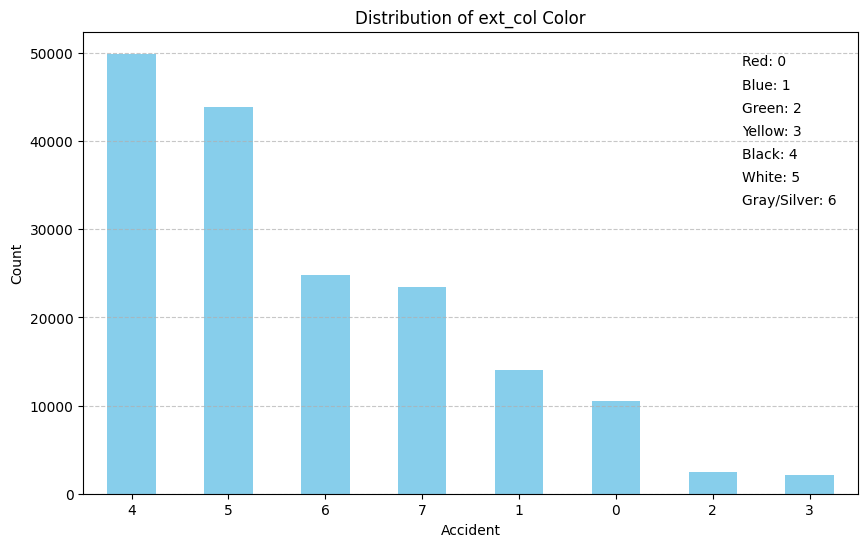

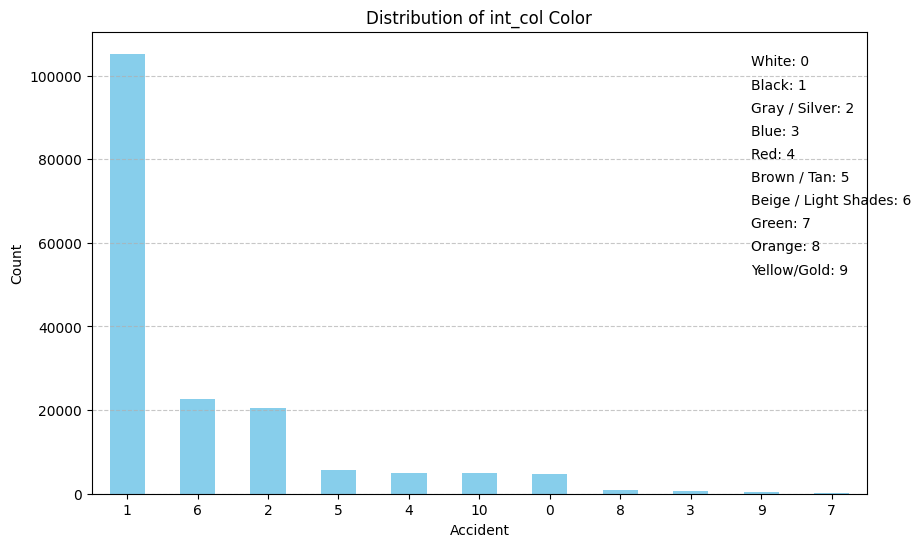

In [111]:
#exterior color:

ext_color = {
    'Red': ['Red', 'Maroon', 'Burgundy', 'Crimson'],
    'Blue': ['Blue','Navy', 'Sky Blue', 'Teal'],
    'Green': ['Green','Olive', 'Forest Green', 'Lime'],
    'Yellow': ['Yellow','Gold', 'Mustard'],
    'Black': ['Black','Jet Black', 'Matte Black'],
    'White': ['White','Pearl White', 'Ivory'],
    'Gray/Silver': ['Gray','Metallic Silver', 'Gunmetal Gray']
}

engine_data=color_grouping(0,ext_color,engine_data)

int_color = {
    'White': ['White', 'Parchment','Ice', 'Light Platinum','Oyster W/Contrast', 'Ceramic', 'Ivory / Ebony', 'Linen', 'Bianco Polar', 
                            'Very Light Cashmere', 'Whisper Beige', 'Silk Beige/Black'],
    'Black': ['Black',  'Ebony', 'Ebony Black', 
                            'Black Onyx', 'Nero', 
                            'Black / Graphite', 'Black/Gun Metal', 'Ebony/Light Oyster Stitch', 
                            'Black w/Red Stitching', 'Anthracite', 'Ebony / Ebony Accents', 'Nero Ade', 'Beluga', 'Porpoise'],
    'Gray / Silver': ['Gray', 'Silver', 'Graphite', 'Charcoal', 'Slate', 'Graphite w/Gun Metal', 'Light Titanium', 'Medium Ash Gray', 
                      'Medium Dark Slate', 'Graystone', 'Light Slate', 'Dark Ash', 'Boulder', 'Titanium'],
    'Blue': ['Blue', 'Navy Pier', 'Gray w/Blue Bolsters',  'Sport'],
    'Red': ['Red', 'Pimento Red w/Ebony', 'Black / Express Red','Hotspur', 'Deep Garnet'],
    'Brown / Tan': ['Brown', 'Mocha', 'Cappuccino', 'Caramel', 'Saddle Brown', 'Tan', 'Camel', 'Hotspur Hide', 
                    'Sahara Tan', 'Cocoa / Dune', 'Camel Leather', 'Silk Beige/Espresso Brown'],
    'Beige / Light Shades': ['Beige', 'Oyster', 'Macchiato', 'Saiga Beige', 'Tan/Ebony', 'Canberra Beige/Black'],
    'Green': ['Green', 'Deep Cypress'],
    'Orange': ['Orange', 'Sakhir Orange/Black', 'Amber'],
    'Yellow/Gold': ['Yellow', 'Gold']}

engine_data=color_grouping(1,int_color, engine_data)


In [112]:
engine_data.head(5)

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,HP,engine_liter,cylinder,mode,transmission_class,fuel_class,HP_class,accident_class,ext_class,int_class
2,2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,...,320.0,5,2,Automatic,2,2,4,0,1,2
4,4,Mercedes-Benz,Metris Base,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,...,208.0,2,0,Automatic,2,0,3,0,4,6
5,5,Audi,A6 2.0T Sport,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,...,252.0,2,0,Automatic,2,0,3,0,5,10
6,6,Audi,A8 L 3.0T,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,...,333.0,3,1,Automatic,2,0,4,0,4,1
7,7,Chevrolet,Silverado 1500 1LZ,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,...,355.0,5,2,Automatic,2,2,4,0,5,2


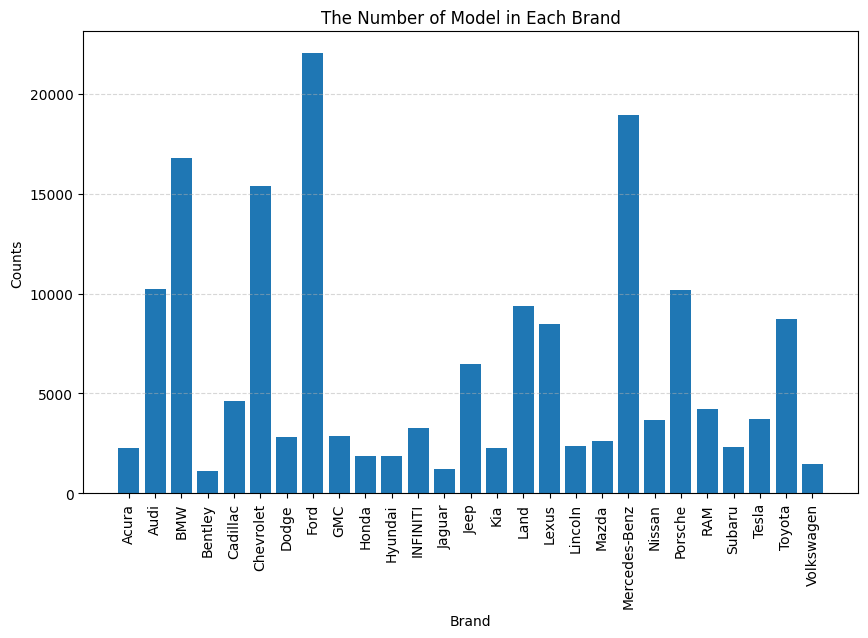

In [113]:
#how the number of model distributes: 
engine_data.groupby('brand')['model'].count().reset_index()

brand_dict = {}

for k,v in engine_data.groupby('brand')['model'].count().items():
    brand_dict[k] = v
column_x = brand_dict.keys()
column_y = brand_dict.values()

plt.figure(figsize=(10, 6))
plt.bar(column_x, column_y)

# Adding labels and title
plt.xlabel('Brand')
plt.ylabel('Counts')
plt.title('The Number of Model in Each Brand')
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Adding a grid to the y-axis
plt.xticks(rotation=90)
# Display the plot
plt.show()


In [114]:
k= variety_checker(engine_data['brand'])
print(k)

['Chevrolet', 'Mercedes-Benz', 'Audi', 'Ford', 'BMW', 'Tesla', 'Cadillac', 'Land', 'GMC', 'Toyota', 'Hyundai', 'RAM', 'INFINITI', 'Jeep', 'Porsche', 'Honda', 'Lexus', 'Dodge', 'Nissan', 'Jaguar', 'Acura', 'Lincoln', 'Kia', 'Bentley', 'Mazda', 'Subaru', 'Volkswagen']


In [115]:
high_luxury = ['Bentley','Mercedes-Benz','Porsche','Land Rover','Jaguar']
mid_luxury = ['Audi','BMW','Tesla','Cadillac','Lexus','Lincoln','INFINITI','Acura']
entry_level_luxury = ['Volkswagen','Subaru','Mazda','Kia']

lux_level = []

for each in engine_data['brand']:
    if each in high_luxury:
        lux_level.append(0)
    elif each in mid_luxury:
        lux_level.append(1)
    elif each in entry_level_luxury:
        lux_level.append(2)
    else: lux_level.append(3)
        
engine_data['luxury'] = lux_level
        
    
    

/tmp/ipykernel_36/1049584225.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engine_data['luxury'] = lux_level


In [116]:
engine_data.head(20)

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,engine_liter,cylinder,mode,transmission_class,fuel_class,HP_class,accident_class,ext_class,int_class,luxury
2,2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,...,5,2,Automatic,2,2,4,0,1,2,3
4,4,Mercedes-Benz,Metris Base,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,...,2,0,Automatic,2,0,3,0,4,6,0
5,5,Audi,A6 2.0T Sport,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,...,2,0,Automatic,2,0,3,0,5,10,1
6,6,Audi,A8 L 3.0T,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,...,3,1,Automatic,2,0,4,0,4,1,1
7,7,Chevrolet,Silverado 1500 1LZ,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,...,5,2,Automatic,2,2,4,0,5,2,3
8,8,Ford,F-150 XLT,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,...,2,1,Automatic,2,0,1,0,5,1,3
9,9,BMW,M4 Base,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,...,3,1,Special/Other,4,0,5,0,4,3,1
10,10,Chevrolet,Camaro 1LT,212500,Gasoline,312.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Gray,At least 1 accident or damage reported,...,3,1,Automatic,2,0,4,1,1,2,3
11,11,Tesla,Model S P100D,81500,Electric,Electric Motor Electric Fuel System,1-Speed A/T,Gray,White,None reported,...,0,5,Automatic,2,3,1,0,6,0,1
12,12,Cadillac,Escalade ESV Platinum,93971,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Black,None reported,...,6,2,Automatic,2,0,5,0,5,1,1


In [118]:
engine_data.isna().sum()

id                        0
brand                     0
model                     0
milage                    0
fuel_type              1074
engine                    0
transmission              0
ext_col                   0
int_col                   0
accident               2152
clean_title           19336
price                     0
Age                       0
HP                        0
engine_liter              0
cylinder                  0
mode                      0
transmission_class        0
fuel_class                0
HP_class                  0
accident_class            0
ext_class                 0
int_class                 0
luxury                    0
dtype: int64

In [117]:
engine_data.head(10)

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,engine_liter,cylinder,mode,transmission_class,fuel_class,HP_class,accident_class,ext_class,int_class,luxury
2,2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,...,5,2,Automatic,2,2,4,0,1,2,3
4,4,Mercedes-Benz,Metris Base,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,...,2,0,Automatic,2,0,3,0,4,6,0
5,5,Audi,A6 2.0T Sport,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,...,2,0,Automatic,2,0,3,0,5,10,1
6,6,Audi,A8 L 3.0T,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,...,3,1,Automatic,2,0,4,0,4,1,1
7,7,Chevrolet,Silverado 1500 1LZ,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,...,5,2,Automatic,2,2,4,0,5,2,3
8,8,Ford,F-150 XLT,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,...,2,1,Automatic,2,0,1,0,5,1,3
9,9,BMW,M4 Base,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,...,3,1,Special/Other,4,0,5,0,4,3,1
10,10,Chevrolet,Camaro 1LT,212500,Gasoline,312.0HP 3.6L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Gray,At least 1 accident or damage reported,...,3,1,Automatic,2,0,4,1,1,2,3
11,11,Tesla,Model S P100D,81500,Electric,Electric Motor Electric Fuel System,1-Speed A/T,Gray,White,None reported,...,0,5,Automatic,2,3,1,0,6,0,1
12,12,Cadillac,Escalade ESV Platinum,93971,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Black,None reported,...,6,2,Automatic,2,0,5,0,5,1,1


In [119]:
engine_data.drop('id', axis=1, inplace=True)
engine_data.drop('model', axis=1, inplace=True)
engine_data.drop('fuel_type', axis=1, inplace=True)
engine_data.drop('engine', axis=1, inplace=True)
engine_data.drop('transmission', axis=1, inplace=True)
engine_data.drop('ext_col', axis=1, inplace=True)
engine_data.drop('int_col', axis=1, inplace=True)
engine_data.drop('accident', axis=1, inplace=True)
engine_data.drop('mode', axis=1, inplace=True)

/tmp/ipykernel_36/4264553856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engine_data.drop('id', axis=1, inplace=True)
/tmp/ipykernel_36/4264553856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engine_data.drop('model', axis=1, inplace=True)
/tmp/ipykernel_36/4264553856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  engine_data.drop('fuel_type', axis=1, inplace=True)
/tmp/ipykernel_36/4264553856.py:4: SettingWithCopyW

In [120]:
engine_data

,brand,milage,clean_title,price,Age,HP,engine_liter,cylinder,transmission_class,fuel_class,HP_class,accident_class,ext_class,int_class,luxury
2,Chevrolet,136731,Yes,13900,22,320.0,5,2,2,2,4,0,1,2,3
4,Mercedes-Benz,7388,Yes,97500,3,208.0,2,0,2,0,3,0,4,6,0
5,Audi,40950,Yes,29950,6,252.0,2,0,2,0,3,0,5,10,1
6,Audi,62200,Yes,28500,8,333.0,3,1,2,0,4,0,4,1,1
7,Chevrolet,102604,Yes,12500,8,355.0,5,2,2,2,4,0,5,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,Cadillac,49000,Yes,27500,7,420.0,6,2,4,0,5,0,5,6,1
188529,Mercedes-Benz,28600,Yes,30000,6,385.0,3,1,2,0,4,1,5,1,0
188530,Mercedes-Benz,13650,Yes,86900,3,469.0,4,2,2,0,5,0,5,1,0
188531,Audi,13895,NaN,84900,2,0.0,3,5,2,0,1,0,6,1,1


In [121]:
variety_checker(engine_data['clean_title'])
#  OUTPUT: ['Yes', nan]
#  as the data is not good, we can ignore it
engine_data=engine_data.drop('clean_title',axis =1)

In [122]:
engine_data=engine_data.drop('HP',axis =1)

In [123]:
engine_data.head(2)

,brand,milage,price,Age,engine_liter,cylinder,transmission_class,fuel_class,HP_class,accident_class,ext_class,int_class,luxury
2,Chevrolet,136731,13900,22,5,2,2,2,4,0,1,2,3
4,Mercedes-Benz,7388,97500,3,2,0,2,0,3,0,4,6,0


In [124]:
#Preserve the data
train_data = engine_data

In [125]:
train_data=train_data.drop('brand',axis =1)

In [126]:
train_data.head()

,milage,price,Age,engine_liter,cylinder,transmission_class,fuel_class,HP_class,accident_class,ext_class,int_class,luxury
2,136731,13900,22,5,2,2,2,4,0,1,2,3
4,7388,97500,3,2,0,2,0,3,0,4,6,0
5,40950,29950,6,2,0,2,0,3,0,5,10,1
6,62200,28500,8,3,1,2,0,4,0,4,1,1
7,102604,12500,8,5,2,2,2,4,0,5,2,3


In [164]:
y = train_data.price
feature = ['milage','Age','engine_liter','cylinder','transmission_class','fuel_class','HP_class','accident_class','ext_class','int_class','luxury']
x = train_data[feature]

In [165]:
x.head()

,milage,Age,engine_liter,cylinder,transmission_class,fuel_class,HP_class,accident_class,ext_class,int_class,luxury
2,136731,22,5,2,2,2,4,0,1,2,3
4,7388,3,2,0,2,0,3,0,4,6,0
5,40950,6,2,0,2,0,3,0,5,10,1
6,62200,8,3,1,2,0,4,0,4,1,1
7,102604,8,5,2,2,2,4,0,5,2,3


In [45]:
from sklearn.preprocessing import StandardScaler
'''
scaler = StandardScaler()
scaled_df = scaler.fit_transform(x)
scaled_df = pd.DataFrame(scaled_df, columns=x.columns)
'''

'\nscaler = StandardScaler()\nscaled_df = scaler.fit_transform(x)\nscaled_df = pd.DataFrame(scaled_df, columns=x.columns)\n'

In [46]:
from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [166]:
feature = ['milage','Age','engine_liter','cylinder','transmission_class','fuel_class','HP_class','accident_class','ext_class','int_class','luxury']


In [181]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib


num_vector = ['milage','Age']
cat_vector = ['engine_liter','cylinder','transmission_class','fuel_class','HP_class','accident_class','ext_class','int_class','luxury']

X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.9, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_vector),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_vector)
    ])


# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    #('regressor', LinearRegression())])
    ('regressor', GradientBoostingRegressor(random_state=42))])


model.fit(X_train, y_train)

#Make predictions on the test data
y_pred = model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Absolute Error: 19010.479908198864
Mean Squared Error: 5740984488.715038


In [182]:
regressor = model.named_steps['regressor'] #access to pipeline
importances = regressor.feature_importances_


feature_names = model.named_steps['preprocessor'].get_feature_names_out() #access to feature name so i can match them with feature importances
print(feature_names)

['num__milage' 'num__Age' 'cat__engine_liter_0' 'cat__engine_liter_1'
 'cat__engine_liter_2' 'cat__engine_liter_3' 'cat__engine_liter_4'
 'cat__engine_liter_5' 'cat__engine_liter_6' 'cat__cylinder_0'
 'cat__cylinder_1' 'cat__cylinder_2' 'cat__cylinder_3' 'cat__cylinder_4'
 'cat__cylinder_5' 'cat__transmission_class_0' 'cat__transmission_class_1'
 'cat__transmission_class_2' 'cat__transmission_class_3'
 'cat__transmission_class_4' 'cat__fuel_class_0' 'cat__fuel_class_1'
 'cat__fuel_class_2' 'cat__fuel_class_3' 'cat__fuel_class_4'
 'cat__fuel_class_5' 'cat__fuel_class_6' 'cat__fuel_class_7'
 'cat__HP_class_1' 'cat__HP_class_2' 'cat__HP_class_3' 'cat__HP_class_4'
 'cat__HP_class_5' 'cat__HP_class_6' 'cat__HP_class_7' 'cat__HP_class_8'
 'cat__HP_class_9' 'cat__HP_class_10' 'cat__accident_class_0'
 'cat__accident_class_1' 'cat__ext_class_0' 'cat__ext_class_1'
 'cat__ext_class_2' 'cat__ext_class_3' 'cat__ext_class_4'
 'cat__ext_class_5' 'cat__ext_class_6' 'cat__ext_class_7'
 'cat__int_class_

In [183]:
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)


In [184]:
feature_importances_df.head(10)

,Feature,Importance
0,num__milage,0.614034
1,num__Age,0.127887
59,cat__luxury_0,0.051266
16,cat__transmission_class_1,0.028415
4,cat__engine_liter_2,0.025792
6,cat__engine_liter_4,0.020854
33,cat__HP_class_6,0.014886
12,cat__cylinder_3,0.010239
11,cat__cylinder_2,0.009893
8,cat__engine_liter_6,0.008748


In [185]:
  # Save the model to a file
joblib.dump(model,'/kaggle/working/GradientBoostingRegressor.pkl')

['/kaggle/working/GradientBoostingRegressor.pkl']

In [186]:
prediction = []
for each in y_pred:
    prediction.append(int(each))
    

In [187]:
test_dict = {'actual': y_test,
            'predict':prediction}

In [188]:
gbr_predict = pd.DataFrame(test_dict)
gbr_predict.head(20)

,actual,predict
10068,33500,43568
50493,22999,21561
164877,21900,26635
179835,54798,54216
171203,38900,56483
106260,40250,68840
170189,11000,14057
180572,48000,109619
25410,12000,24992
11545,8750,17681


# AUTOGLUON METHOD

> **#recalling data in original forms**

In [88]:
trainlink = '/kaggle/input/playground-series-s4e9/train.csv'

train = pd.DataFrame(pd.read_csv(trainlink))

In [89]:
len(train)

188533

In [65]:
train_autoML = data_process(train)

In [67]:
train_autoML.head(3)

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Age,HP,engine_liter,cylinder,mode,transmission_class
0,0,MINI,Cooper S Base,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,17,172.0,1.6,4.0,Automatic,2
1,1,Lincoln,LS V8,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,252.0,3.9,8.0,Automatic,2
2,2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,22,320.0,5.3,8.0,Automatic,2


In [71]:
train_autoML=train_autoML.drop('mode',axis = 1)

In [72]:
train_autoML = train_autoML.drop('transmission_class',axis = 1)

KeyError: "['transmission_class'] not found in axis"

In [73]:
train_autoML.head(2)

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Age,HP,engine_liter,cylinder
0,0,MINI,Cooper S Base,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,17,172.0,1.6,4.0
1,1,Lincoln,LS V8,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,252.0,3.9,8.0


In [80]:
train_autoML = train_autoML.drop('id',axis = 1)
train_autoML = train_autoML.drop('engine',axis = 1)

In [81]:
train_autoML.head(2)

,brand,model,milage,fuel_type,transmission,ext_col,int_col,accident,clean_title,price,Age,HP,engine_liter,cylinder
0,MINI,Cooper S Base,213000,Gasoline,A/T,Yellow,Gray,None reported,Yes,4200,17,172.0,1.6,4.0
1,Lincoln,LS V8,143250,Gasoline,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,252.0,3.9,8.0


In [74]:
pip install scikit-learn==0.24.2 autogluon==0.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 20.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [1506 lines of output]
      <string>:17: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
      Partial import of sklearn during the build process.
      <string>:116: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more details, see:
          https://numpy.org/devdocs/reference/dis

In [75]:
pip install autogluon.tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.1/312.1 kB 8.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 84.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 44.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 89.3 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.0
    Uninstalling scipy-1.14.0:
      Successfully uninstalled scipy-1.14.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  

In [82]:
label = 'price'

autoML_train = train_autoML.sample(frac = 0.8,random_state = 42)
autoML_test = train_autoML.drop(autoML_train.index)

In [77]:
pip install scikit-learn==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 47.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.0
    Uninstalling scikit-learn-1.4.0:
      Successfully uninstalled scikit-learn-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-core 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.2.2 which is incompatible.
autogluon-features 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.2.2 which is incompatible.
autogluon-tabular 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.2.2 which is incompatible.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-c

In [85]:
model = TabularPredictor(label='price',
                                eval_metric='rmse',
                                problem_type='regression').fit(autoML_train,
                                                           presets='best_quality',
                                                            time_limit=3600*4,
                                                           excluded_model_types=['KNN','NN_TORCH'],
                                                              ag_args_fit={'num_gpus': 1})

No path specified. Models will be saved in: "AutogluonModels/ag-20241008_191209"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jun 27 20:43:36 UTC 2024
CPU Count:          4
Memory Avail:       29.09 GB / 31.36 GB (92.8%)
Disk Space Avail:   19.21 GB / 19.52 GB (98.4%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets o

In [83]:
from autogluon.tabular import TabularPredictor

hyperparameters = {
     'GBM': {},        # LightGBM (GBM stands for Gradient Boosting Machine)
    'CAT': {}        # CatBoost        
}

predictor = TabularPredictor(label = 'price',eval_metric = 'mae').fit(
    autoML_train,
    hyperparameters = hyperparameters
)


No path specified. Models will be saved in: "AutogluonModels/ag-20241008_185318"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jun 27 20:43:36 UTC 2024
CPU Count:          4
Memory Avail:       29.15 GB / 31.36 GB (93.0%)
Disk Space Avail:   19.25 GB / 19.52 GB (98.6%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time

In [86]:
predictor = TabularPredictor.load("AutogluonModels/ag-20241008_185318")

In [87]:
performance = predictor.evaluate(autoML_test) 
print("Model Performance:", performance)
print('MAE:',performance['mean_absolute_error'])

Model Performance: {'mean_absolute_error': -19487.109206010944, 'root_mean_squared_error': -76374.16550474914, 'mean_squared_error': -5833013156.546813, 'r2': 0.13687458396709873, 'pearsonr': 0.3700450626875896, 'median_absolute_error': -8336.2265625}
MAE: -19487.109206010944


In [189]:
performance['mean_absolute_error']

-19487.109206010944

In [190]:
importance = predictor.feature_importance(autoML_train)
print("Feature Importance:\n", importance)

Computing feature importance via permutation shuffling for 13 features using 5000 rows with 5 shuffle sets...
	17.18s	= Expected runtime (3.44s per shuffle set)
	11.98s	= Actual runtime (Completed 5 of 5 shuffle sets)


Feature Importance:
                importance      stddev       p_value  n     p99_high  \
milage        5698.591385  346.815087  1.638179e-06  5  6412.688443   
Age           3543.957792  103.925504  8.863757e-08  5  3757.941841   
model          917.936839   88.472181  1.022815e-05  5  1100.102282   
HP             753.403747   93.965560  2.844400e-05  5   946.880134   
engine_liter   625.662566  105.334061  9.286646e-05  5   842.546853   
brand          520.572075   31.640291  1.629609e-06  5   585.719872   
transmission   462.862674   50.984050  1.738268e-05  5   567.839537   
ext_col        254.625845   22.852031  7.702306e-06  5   301.678492   
int_col        147.646421   39.428753  5.563328e-04  5   228.830770   
cylinder       110.258631   11.468617  1.384637e-05  5   133.872672   
fuel_type       57.827450   14.970690  4.940447e-04  5    88.652308   
clean_title     50.217963   14.587645  7.661914e-04  5    80.254126   
accident        -0.588864   24.273368  5.203299e-01  5  

In [191]:
auto_prediction = predictor.predict(autoML_test.drop(columns=['price']))


In [192]:
test_dict = {'actual': autoML_test['price'],
            'predict':auto_prediction}

automl_predict = pd.DataFrame(test_dict)
automl_predict.head(20)

,actual,predict
5,29950,34192.777344
10,7950,10987.683594
15,44900,57812.554688
16,68500,77452.054688
18,9999,14075.904297
26,25900,32485.593750
28,3499,10467.178711
36,165000,52559.593750
37,45000,92982.468750
43,244896,92522.468750


# TESTING

In [193]:
testlink = '/kaggle/input/playground-series-s4e9/train.csv'

test = pd.DataFrame(pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv'))
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,125690.0,251377.500000,36283.722005,188533.0,219955.25,251377.5,282799.75,314222.0
model_year,125690.0,2015.797526,5.673797,1974.0,2013.00,2017.0,2020.00,2024.0
milage,125690.0,66042.581510,50223.858435,100.0,24500.00,57500.0,95798.00,405000.0


In [194]:
test_data=data_process(test)

In [195]:
test_data.head()

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,Age,HP,engine_liter,cylinder,mode,transmission_class
0,188533,Land,Rover LR2 Base,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes,9,240.0,2.0,4.0,Automatic,2
1,188534,Land,Rover Defender SE,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes,4,395.0,3.0,6.0,Automatic,2
2,188535,Ford,Expedition Limited,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN,2,0.0,3.5,6.0,Automatic,2
3,188536,Audi,A6 2.0T Sport,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN,8,0.0,2.0,0.0,Automatic,2
4,188537,Audi,A6 2.0T Premium Plus,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes,6,252.0,2.0,4.0,Automatic,2


In [196]:
#transform the test data to be predict

#lets transform categorical information to numerical information
# ----------------------------------------------------------------------------------------

#Fuel_type
# -------------------------------------
fuel_data = []
#print(dt_car['fuel_type'].value_counts())

for each in test_data['fuel_type']:
    if each == 'Gasoline':
        fuel_data.append(0)
    elif each == 'Hybrid':
        fuel_data.append(1)
    elif each == 'E85 Flex Fuel':
        fuel_data.append(2)
    elif each == 'Electric':
        fuel_data.append(3)
    elif each == 'Diesel':
        fuel_data.append(4)
    elif each == '–':
        fuel_data.append(5)
    elif each == 'Plug-In Hybrid':
        fuel_data.append(6)
    else:
        fuel_data.append(7)
test_data['fuel_class'] = fuel_data

#Cylinder_type
# -------------------------------------
volume = []

for each in test_data['cylinder']:
    if each == 4.0:
        volume.append(0)
    elif each == 6.0:
        volume.append(1)
    elif each == 8.0:
        volume.append(2)
    elif each == 10.0:
        volume.append(3)
    elif each == 12.0:
        volume.append(4)
    elif each == 0.0:
        volume.append(5)
    else:
        volume.append(6)
test_data['cylinder'] = volume
        

In [145]:
test_data.head()

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,Age,HP,engine_liter,cylinder,mode,transmission_class,fuel_class
0,188533,Land,Rover LR2 Base,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes,9,240.0,2.0,5,Automatic,2,0
1,188534,Land,Rover Defender SE,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes,4,395.0,3.0,6,Automatic,2,1
2,188535,Ford,Expedition Limited,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN,2,0.0,3.5,6,Automatic,2,0
3,188536,Audi,A6 2.0T Sport,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN,8,0.0,2.0,6,Automatic,2,0
4,188537,Audi,A6 2.0T Premium Plus,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes,6,252.0,2.0,5,Automatic,2,0


In [197]:
engine_list=test_data['engine_liter']
k = []

for each in engine_list:
    if each < 1:
            k.append(0)
    elif each < 2:
            k.append(1)
    elif each < 3:
            k.append(2)
    elif each < 4:
            k.append(3)
    elif each < 5:
            k.append(4)
    elif each < 6:
            k.append(5)
    elif each < 7:
            k.append(6)
    elif each < 8:
            k.append(7)
    else:
            k.append(8)
test_data['engine_liter'] = k

In [147]:
test_data.head()

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,Age,HP,engine_liter,cylinder,mode,transmission_class,fuel_class
0,188533,Land,Rover LR2 Base,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes,9,240.0,2,5,Automatic,2,0
1,188534,Land,Rover Defender SE,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes,4,395.0,3,6,Automatic,2,1
2,188535,Ford,Expedition Limited,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN,2,0.0,3,6,Automatic,2,0
3,188536,Audi,A6 2.0T Sport,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN,8,0.0,2,6,Automatic,2,0
4,188537,Audi,A6 2.0T Premium Plus,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes,6,252.0,2,5,Automatic,2,0


In [198]:
#HorsePower_type
# -------------------------------------

hp_list=test_data['HP']
new_list = []

for each in hp_list:
    if each < 100:
            new_list.append(1)
    elif each < 200:
            new_list.append(2)
    elif each < 300:
            new_list.append(3)
    elif each < 400:
            new_list.append(4)
    elif each < 500:
            new_list.append(5)
    elif each < 600:
            new_list.append(6)
    elif each < 700:
            new_list.append(7)
    elif each < 800:
            new_list.append(8)
    elif each < 900:
            new_list.append(9)
    else: 
        new_list.append(10)

test_data['HP_class'] = new_list

In [199]:
mylist = test_data['accident']
newlist = []
ctr = []

for each in mylist:
    if each == 'None reported':
        newlist.append(0)
        ctr.append(0)
    elif each == 'At least 1 accident or damage reported':
        newlist.append(1)
        ctr.append(1)
    else:
        newlist.append(each) #first of all, i want not to touch NA then i will calculate mean value for nan to be filled
print(variety_checker(newlist))
 
meanvalue = sum(ctr)/len(ctr)
if meanvalue < 0.5:
    x = 0
else:
    x = 1
modified_newlist = [x if each not in [0, 1] else each for each in newlist]

test_data['accident_class'] = modified_newlist


[0, 1, nan]


In [200]:
test_data.head()

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,Age,HP,engine_liter,cylinder,mode,transmission_class,fuel_class,HP_class,accident_class
0,188533,Land,Rover LR2 Base,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes,9,240.0,2,0,Automatic,2,0,3,0
1,188534,Land,Rover Defender SE,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes,4,395.0,3,1,Automatic,2,1,4,0
2,188535,Ford,Expedition Limited,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN,2,0.0,3,1,Automatic,2,0,1,0
3,188536,Audi,A6 2.0T Sport,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN,8,0.0,2,5,Automatic,2,0,1,0
4,188537,Audi,A6 2.0T Premium Plus,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes,6,252.0,2,0,Automatic,2,0,3,0


nerede
{'Red': 0, 'Blue': 1, 'Green': 2, 'Yellow': 3, 'Black': 4, 'White': 5, 'Gray/Silver': 6}
nerede
{'White': 0, 'Black': 1, 'Gray / Silver': 2, 'Blue': 3, 'Red': 4, 'Brown / Tan': 5, 'Beige / Light Shades': 6, 'Green': 7, 'Orange': 8, 'Yellow/Gold': 9}


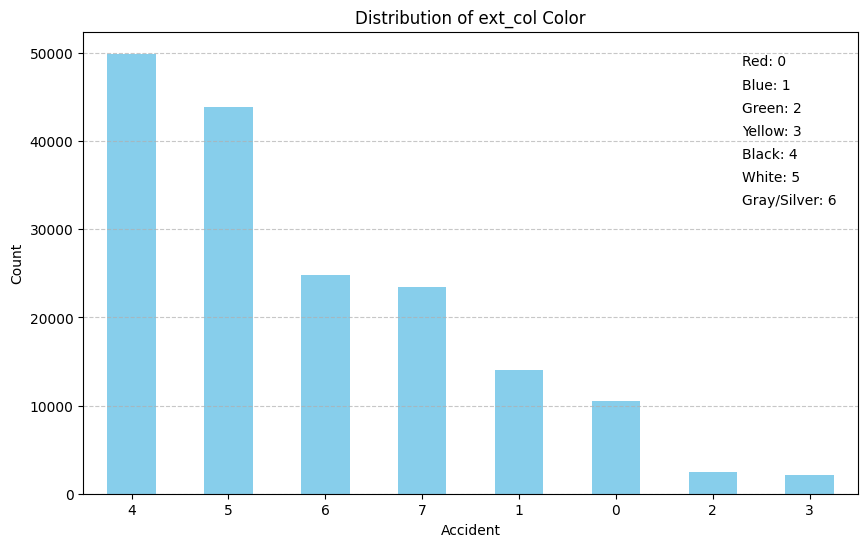

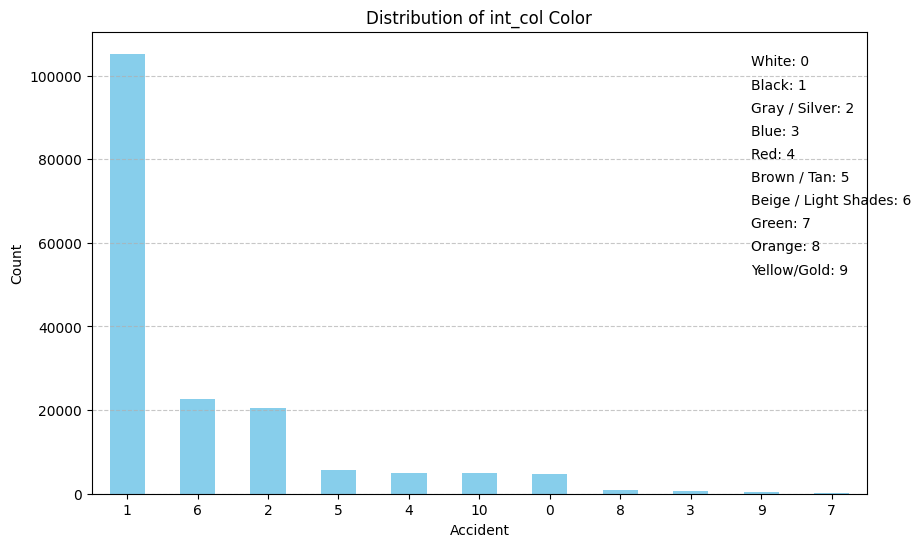

In [201]:


ext_color = {
    'Red': ['Red', 'Maroon', 'Burgundy', 'Crimson'],
    'Blue': ['Blue','Navy', 'Sky Blue', 'Teal'],
    'Green': ['Green','Olive', 'Forest Green', 'Lime'],
    'Yellow': ['Yellow','Gold', 'Mustard'],
    'Black': ['Black','Jet Black', 'Matte Black'],
    'White': ['White','Pearl White', 'Ivory'],
    'Gray/Silver': ['Gray','Metallic Silver', 'Gunmetal Gray']
}

test_data=color_grouping(0,ext_color, test_data)

int_color = {
    'White': ['White', 'Parchment','Ice', 'Light Platinum','Oyster W/Contrast', 'Ceramic', 'Ivory / Ebony', 'Linen', 'Bianco Polar', 
                            'Very Light Cashmere', 'Whisper Beige', 'Silk Beige/Black'],
    'Black': ['Black',  'Ebony', 'Ebony Black', 
                            'Black Onyx', 'Nero', 
                            'Black / Graphite', 'Black/Gun Metal', 'Ebony/Light Oyster Stitch', 
                            'Black w/Red Stitching', 'Anthracite', 'Ebony / Ebony Accents', 'Nero Ade', 'Beluga', 'Porpoise'],
    'Gray / Silver': ['Gray', 'Silver', 'Graphite', 'Charcoal', 'Slate', 'Graphite w/Gun Metal', 'Light Titanium', 'Medium Ash Gray', 
                      'Medium Dark Slate', 'Graystone', 'Light Slate', 'Dark Ash', 'Boulder', 'Titanium'],
    'Blue': ['Blue', 'Navy Pier', 'Gray w/Blue Bolsters',  'Sport'],
    'Red': ['Red', 'Pimento Red w/Ebony', 'Black / Express Red','Hotspur', 'Deep Garnet'],
    'Brown / Tan': ['Brown', 'Mocha', 'Cappuccino', 'Caramel', 'Saddle Brown', 'Tan', 'Camel', 'Hotspur Hide', 
                    'Sahara Tan', 'Cocoa / Dune', 'Camel Leather', 'Silk Beige/Espresso Brown'],
    'Beige / Light Shades': ['Beige', 'Oyster', 'Macchiato', 'Saiga Beige', 'Tan/Ebony', 'Canberra Beige/Black'],
    'Green': ['Green', 'Deep Cypress'],
    'Orange': ['Orange', 'Sakhir Orange/Black', 'Amber'],
    'Yellow/Gold': ['Yellow', 'Gold']}

test_data=color_grouping(1,int_color, test_data)



In [ ]:
test_data.head()

In [202]:
high_luxury = ['Bentley','Mercedes-Benz','Porsche','Land Rover','Jaguar']
mid_luxury = ['Audi','BMW','Tesla','Cadillac','Lexus','Lincoln','INFINITI','Acura']
entry_level_luxury = ['Volkswagen','Subaru','Mazda','Kia']

lux_level = []

for each in test_data['brand']:
    if each in high_luxury:
        lux_level.append(0)
    elif each in mid_luxury:
        lux_level.append(1)
    elif each in entry_level_luxury:
        lux_level.append(2)
    else: lux_level.append(3)
        
test_data['luxury'] = lux_level
        

In [203]:
test_data.head()

,id,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,engine_liter,cylinder,mode,transmission_class,fuel_class,HP_class,accident_class,ext_class,int_class,luxury
0,188533,Land,Rover LR2 Base,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,...,2,0,Automatic,2,0,3,0,5,6,3
1,188534,Land,Rover Defender SE,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,...,3,1,Automatic,2,1,4,0,7,1,3
2,188535,Ford,Expedition Limited,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,...,3,1,Automatic,2,0,1,0,5,1,3
3,188536,Audi,A6 2.0T Sport,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,...,2,5,Automatic,2,0,1,0,3,1,1
4,188537,Audi,A6 2.0T Premium Plus,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,...,2,0,Automatic,2,0,3,0,6,1,1


In [204]:
test_data.drop('id', axis=1, inplace=True)
test_data.drop('model', axis=1, inplace=True)
test_data.drop('fuel_type', axis=1, inplace=True)
test_data.drop('engine', axis=1, inplace=True)
test_data.drop('transmission', axis=1, inplace=True)
test_data.drop('ext_col', axis=1, inplace=True)
test_data.drop('int_col', axis=1, inplace=True)
test_data.drop('accident', axis=1, inplace=True)
test_data.drop('mode', axis=1, inplace=True)

In [158]:
test_data.head()

,milage,Age,engine_liter,cylinder,transmission_class,fuel_class,HP_class,accident_class,ext_class,int_class,luxury
0,98000,9,2,5,2,0,3,0,5,6,3
1,9142,4,3,6,2,1,4,0,7,1,3
2,28121,2,3,6,2,0,1,0,5,1,3
3,61258,8,2,6,2,0,1,0,3,1,1
4,59000,6,2,5,2,0,3,0,6,1,1


In [205]:
test_data.drop('clean_title', axis=1, inplace=True)

In [ ]:
test_data

In [206]:
test_data.drop('brand', axis=1, inplace=True)

In [207]:
test_data.drop('HP', axis=1, inplace=True)

In [208]:
test_data.head()

,milage,Age,engine_liter,cylinder,transmission_class,fuel_class,HP_class,accident_class,ext_class,int_class,luxury
0,98000,9,2,0,2,0,3,0,5,6,3
1,9142,4,3,1,2,1,4,0,7,1,3
2,28121,2,3,1,2,0,1,0,5,1,3
3,61258,8,2,5,2,0,1,0,3,1,1
4,59000,6,2,0,2,0,3,0,6,1,1


In [209]:
feature = ['milage','Age','engine_liter','cylinder','transmission_class','fuel_class','HP_class','accident_class','ext_class','int_class','luxury']
#y_pred_test = model.predict(test_data[feature],batch_size= 32, verbose=0)
predictions = model.predict(test_data)
y_pred = []
for each in predictions:
    y_pred.append(int(each))
    



In [210]:
id = pd.DataFrame(pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv'))['id']


In [211]:
mycsv = {
    'id' : id,
    'price' : y_pred
}

myout = pd.DataFrame(mycsv)
myout.head(5)

,id,price
0,188533,16160
1,188534,66373
2,188535,57986
3,188536,24877
4,188537,29428


In [212]:
mydata = pd.DataFrame(mycsv) 
mydata.to_csv('/kaggle/working/myresult.csv', index=False)